In [145]:
import sys
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as jutil
import equinox as eqx
import optax
import importlib

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)
    
import models
importlib.reload(models)

# Set the random seed for reproducibility
key = jax.random.PRNGKey(0)

# Assuming input sizes
daily_in_size = 2    # Number of features in daily time series data
irregular_in_size = 6  # Number of features in irregular time series data
static_in_size = 3    # Number of static features
out_size = 1          # Output size
hidden_size = 50      # Size of hidden layers in LSTM cells
batch_size = 32       # Number of samples in a batch
seq_length = 20     # Number of time steps for daily data

# Generate sample data
data = {
    'x_dd': jax.random.normal(key, (batch_size, seq_length, daily_in_size)),
    'x_di': jax.random.normal(key, (batch_size, seq_length, irregular_in_size)),
    'x_s': jax.random.normal(key, (batch_size, static_in_size)),
    'y': jax.random.normal(key, (batch_size, out_size))
}

# Generate a mask with the same shape as x
mask = jax.random.bernoulli(key, p=0.5, shape=data['x_di'].shape[:2])
mask = jnp.expand_dims(mask, axis=-1)  # Add dimension to match x_di shape
data['x_di'] = jnp.where(mask, jnp.nan, data['x_di'])

@eqx.filter_value_and_grad
def compute_loss(model, data):
    y_pred = jax.vmap(model)(data)
    loss = jnp.mean(jnp.square(data['y'][...,-1] - y_pred[...,-1]))
    return loss

# Create the model
key, subkey = jax.random.split(key)
model = models.TAPLSTM(daily_in_size, irregular_in_size, static_in_size, out_size, hidden_size, key=subkey, dropout=0.1)

optim = optax.adam(0.01)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

loss, grads = compute_loss(model, data)
updates, opt_state = optim.update(grads, opt_state)
trained_model = eqx.apply_updates(model, updates)


grad_norms = jutil.tree_map(jnp.linalg.norm, grads)
grad_norms = jutil.tree_leaves_with_path(grad_norms)
# Check each gradient norm
for keypath, norm in grad_norms:
    key = jutil.keystr(keypath)
    if norm < 1e-6:  # Threshold for vanishing gradients
        print(f"Warning: Vanishing gradient detected at {key} with norm {norm}")
    elif norm > 1e3:  # Threshold for exploding gradients
        print(f"Warning: Exploding gradient detected at {key} with norm {norm}")

dt: 1, weight:[0.49293557]
dt: 3, weight:[0.47803473]
dt: 4, weight:[0.45162055]
dt: 1, weight:[0.49025115]
dt: 5, weight:[0.4325421]
dt: 3, weight:[0.44139054]
dt: 2, weight:[0.481188]
dt: 2, weight:[0.48723364]
dt: 2, weight:[0.4834391]
dt: 2, weight:[0.47810912]
dt: 7, weight:[0.49568826]
dt: 1, weight:[0.47559327]
dt: 2, weight:[0.47935548]
dt: 4, weight:[0.45547628]
dt: 1, weight:[0.485601]
dt: 3, weight:[0.4801867]
dt: 1, weight:[0.49775577]
dt: 1, weight:[0.49064937]
dt: 3, weight:[0.45944804]
dt: 3, weight:[0.43549195]
dt: 2, weight:[0.48835236]
dt: 2, weight:[0.47354257]
dt: 3, weight:[0.46835673]
dt: 2, weight:[0.47408298]
dt: 1, weight:[0.488603]
dt: 2, weight:[0.47466084]
dt: 1, weight:[0.49150977]
dt: 2, weight:[0.4787556]
dt: 1, weight:[0.4931608]
dt: 3, weight:[0.4674464]
dt: 1, weight:[0.49192545]
dt: 5, weight:[0.43720794]


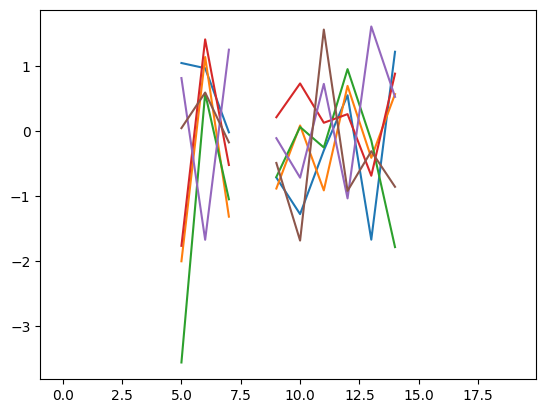

In [137]:
plt.plot(data['x_di'][0,...])

In [147]:
# opt_state[0].mu.ealstm_d.cell.weight_ih
opt_state[0].mu.mlp_attention.layers[1].weight

Array([[ 0.0000000e+00, -6.3063942e-07, -6.6519578e-07, ...,
         0.0000000e+00, -1.6154829e-06,  0.0000000e+00],
       [-7.6083270e-06, -1.9065968e-05,  1.4811302e-06, ...,
        -1.2244305e-07, -2.1071630e-05, -3.4180725e-06],
       [ 5.2454152e-09, -2.4281360e-06, -4.8182737e-06, ...,
        -3.2850192e-08, -1.0442034e-05, -2.0005196e-07],
       ...,
       [-2.1158726e-06, -3.1669738e-06, -2.0466075e-06, ...,
         1.7510846e-08,  3.2757652e-07, -5.9957205e-07],
       [ 1.1330403e-05,  1.7944536e-05, -6.5094133e-07, ...,
        -1.0784646e-07,  6.8614063e-06, -7.3760538e-07],
       [ 4.7339222e-06,  4.8814691e-06,  4.8733426e-08, ...,
         0.0000000e+00,  1.2876629e-07,  2.5122490e-06]], dtype=float32)

In [52]:
grads.mlp_attention.layers[1].weight

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [64]:
trained_model.ealstm_d.cell.weight_ih - model.ealstm_d.cell.weight_ih
# trained_model.mlp_attention.layers[1].weight - model.mlp_attention.layers[1].weight

Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)